### Load the whole data

In [1]:
%run ../src/functions/shared/data_loader/data_loader_pipeline_run.py

2025-08-19 16:08:51.049 | INFO     | None:setup_root_path:13 - Root path set to: /media/racah/2b2b05ab-497e-47ab-a698-6e77a3b775c4/grisha/for_ProtLigMap


2025-08-19 16:08:52.671 | INFO     | None:<module>:22 - Notebook environment ready!
2025-08-19 16:08:52.673 | SUCCESS  | src.utils.file_system:check_directory_exists:52 - Directory found: /media/racah/2b2b05ab-497e-47ab-a698-6e77a3b775c4/grisha/for_ProtLigMap
2025-08-19 16:08:52.673 | SUCCESS  | src.utils.file_system:check_directory_exists:52 - Directory found: /media/racah/2b2b05ab-497e-47ab-a698-6e77a3b775c4/grisha/for_ProtLigMap/data/pdbbind/metadata/generated/core_metadata/backbone/gathered_data_for_preproc
2025-08-19 16:08:52.673 | SUCCESS  | src.utils.file_system:check_directory_exists:52 - Directory found: /media/racah/2b2b05ab-497e-47ab-a698-6e77a3b775c4/grisha/for_ProtLigMap/data/pdbbind/core/stage_3_backbone_processed_outputs
2025-08-19 16:08:53.500 | SUCCESS  | src.utils.file_system:check_directory_exists:52 - Directory found: /media/racah/2b2b05ab-497e-47ab-a698-6e77a3b775c4/grisha/for_ProtLigMap/models/trained
2025-08-19 16:08:53.501 | SUCCESS  | src.utils.file_system:chec

### Aggregate the proteins and standardize their dimensions towards data split

In [3]:
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler, normalize, KBinsDiscretizer
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN

# === Load raw data ===

#
# raw = before split, before any preprocssing, before any filtering
# 


prot_raw = np.stack(data["protein_vecs"])        # shape (N, D1)
pic50_raw = np.array(data["pic50_vals"])        # shape (N,)
ids_raw = np.array(data["valid_keys"])        # shape (N,)
fs_raw = np.array(data["embedding_matrix"]) # shape (N, D2)

# === Step 1: DBSCAN aggregation on proteins ===
db = DBSCAN(eps=1e-3, min_samples=1, metric='euclidean')
prot_raw__agg_labels = db.fit_predict(prot_raw) # protein aggregation labels of all the prot_raw labels are from 0 to ~5K
unique_agg_labels = np.unique(prot_raw__agg_labels) # all unique labels of protein agregation

dict_agg_label_to_idx_raw = {i: np.where(prot_raw__agg_labels == lbl)[0].tolist() for i, lbl in enumerate(unique_agg_labels)} # dictionary (key = unique prot agg label, value = indexes in original protein_raw)




# Agregation of proteins, pic50 and ids

# protein raw agregated
prot_raw_agg = np.vstack([
    prot_raw[prot_raw__agg_labels == lbl].mean(axis=0) for lbl in unique_agg_labels
]) 
# Agregating pic50 by highest value since it's the original before other docking versions
pic50_raw_agg = np.array([np.max(pic50_raw[prot_raw__agg_labels == lbl]) for lbl in unique_agg_labels]) # pic50 raw agregated
ids_raw_agg = [ids_raw[prot_raw__agg_labels == lbl].tolist() for lbl in unique_agg_labels] # ids raw agregated list of lists of ids_raw




print(f"Aggregated from {len(prot_raw)} to {len(prot_raw_agg)} unique reps")

# === Step 2: Standardize + PCA + Normalize aggregated protein embeddings ===
prot_raw_agg_std = StandardScaler().fit_transform(prot_raw_agg)
prot_raw_agg_std_proj = PCA(n_components=0.95).fit_transform(prot_raw_agg_std)
prot_agg_proc = normalize(prot_raw_agg_std_proj, norm='l2')



Aggregated from 97380 to 5279 unique reps


We've sucsesfully diminished the protein dimentions from (97380, 320) to (5279, 73) and normalized them. Now we can use clustering method on the proteins and on the pic50, and using stratified split, we can split, with respect to to protein and pic50 distributions. The problem is that in many cases, splitting the data causes many classes to have single value. Let's calculate then the sweet spot for that.

In [4]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.decomposition import PCA
from collections import Counter
import numpy as np

def singleton_stats_per_combination(prot_agg_proc, pic50_raw_agg, cluster_range, pic50_bin_range):
    results = {}

    # Standardize and project

    for n_clusters in cluster_range:
        clusters = KMeans(n_clusters=n_clusters, random_state=42).fit_predict(prot_agg_proc)

        for n_pic_bins in pic50_bin_range:
            pic_bins = np.digitize(pic50_raw_agg, np.histogram(pic50_raw_agg, bins=n_pic_bins)[1])
            strat_labels = clusters * 1000 + pic_bins  # Ensure unique labels
            counts = Counter(strat_labels)
            n_singletons = sum(1 for v in counts.values() if v == 1)
            total = len(counts)
            ratio = n_singletons / total
            results[(n_clusters, n_pic_bins)] = {
                "n_singletons": n_singletons,
                "n_total_bins": total,
                "ratio": ratio
            }

    return results

# === Run the grid search ===
cluster_range = list(range(5, 50, 5))       # 5, 10, ..., 45
pic50_bin_range = list(range(4, 11))        # 4 to 10 bins

singleton_stats = singleton_stats_per_combination(
    prot_raw_agg, pic50_raw_agg,
    cluster_range, pic50_bin_range
)

# === Sort and print results ===
sorted_results = sorted(singleton_stats.items(), key=lambda x: x[1]["n_singletons"])

print(f"{'Clusters':>8} | {'pIC50 bins':>10} | {'Singletons':>10} | {'Total Bins':>11} | {'Ratio':>7}")
print("-" * 55)
for (n_clusters, n_bins), stats in sorted_results:
    print(f"{n_clusters:>8} | {n_bins:>10} | {stats['n_singletons']:>10} | {stats['n_total_bins']:>11} | {stats['ratio']:.2%}")

# === Best configuration ===
best_config = sorted_results[0]
n_clusters_best, n_bins_best = best_config[0]
stats_best = best_config[1]
print("\nBest configuration:")
print(f"Clusters = {n_clusters_best}, pIC50 bins = {n_bins_best}")
print(f"Singletons = {stats_best['n_singletons']}, Total bins = {stats_best['n_total_bins']}, Ratio = {stats_best['ratio']:.2%}")


Clusters | pIC50 bins | Singletons |  Total Bins |   Ratio
-------------------------------------------------------
       5 |          4 |          2 |          21 | 9.52%
       5 |          5 |          3 |          25 | 12.00%
       5 |          7 |          3 |          34 | 8.82%
      10 |          7 |          3 |          62 | 4.84%
       5 |          6 |          4 |          30 | 13.33%
       5 |          8 |          4 |          38 | 10.53%
       5 |          9 |          4 |          41 | 9.76%
      10 |          5 |          4 |          45 | 8.89%
      10 |          6 |          4 |          53 | 7.55%
      15 |          5 |          4 |          64 | 6.25%
      15 |          6 |          4 |          76 | 5.26%
       5 |         10 |          5 |          45 | 11.11%
      10 |          4 |          5 |          39 | 12.82%
      10 |          9 |          5 |          74 | 6.76%
      15 |          7 |          5 |          87 | 5.75%
      20 |          5 |  

We've picked 5 and 4 for clustering/bin values for kmeans and pic50, since the number of singeltons is the lowest in this case, and the number of total bins is still acceptable given the fact that we have ~5K number of proteins overall.

Lets split the data while making sure there is equal distribution between train and val sets in both pic50 and protein terms, and leave out singletons

In [5]:
# === Step 3: Cluster aggregated proteins for stratification ===

n_protein_bins_all = 5
n_pic50_bins_all = 4

clusters = KMeans(n_clusters=n_protein_bins_all, random_state=42).fit_predict(prot_agg_proc)

# Bin pIC50 into 4 bins for stratification
pic_bins = np.digitize(pic50_raw_agg, np.histogram(pic50_raw_agg, bins=n_pic50_bins_all)[1])


# Combine cluster and bin labels for stratification
strat_labels = clusters * 100 + pic_bins


# Remove rare strata (labels with < 2 samples)
counts = Counter(strat_labels)
rare = {lbl for lbl, c in counts.items() if c < 2}
mask = np.array([lbl not in rare for lbl in strat_labels])

agg_idx = np.where(mask)[0]

prot_raw_agg_filtered = prot_raw_agg[mask] # protein raw agregated after filtering out protein/s that are too rare to be included in the data (can't split data with it)
filtered_strat = strat_labels[mask] # filtered stratified labels

# Stratified train/val split (30% val)
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
train_agg_idx, val_agg_idx = next(sss.split(prot_raw_agg_filtered, filtered_strat)) # indexes in the agregated form split to train and val


# === Split agregated data ===
prot_raw_agg_train = prot_raw_agg[train_agg_idx]
prot_raw_agg_val   = prot_raw_agg[val_agg_idx]

pic50_raw_agg_train = pic50_raw_agg[train_agg_idx]
pic50_raw_agg_val   = pic50_raw_agg[val_agg_idx]



Great, now let's see how similar the distibutions are, remember these plots are for protein and pic50 after agregation and filtering

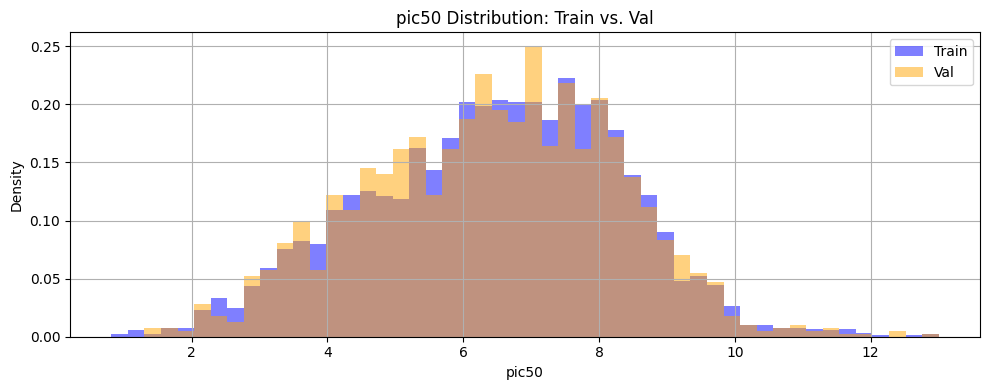

Distribution similarity (pic50):
KL divergence:         0.0438
Wasserstein distance:  0.0539


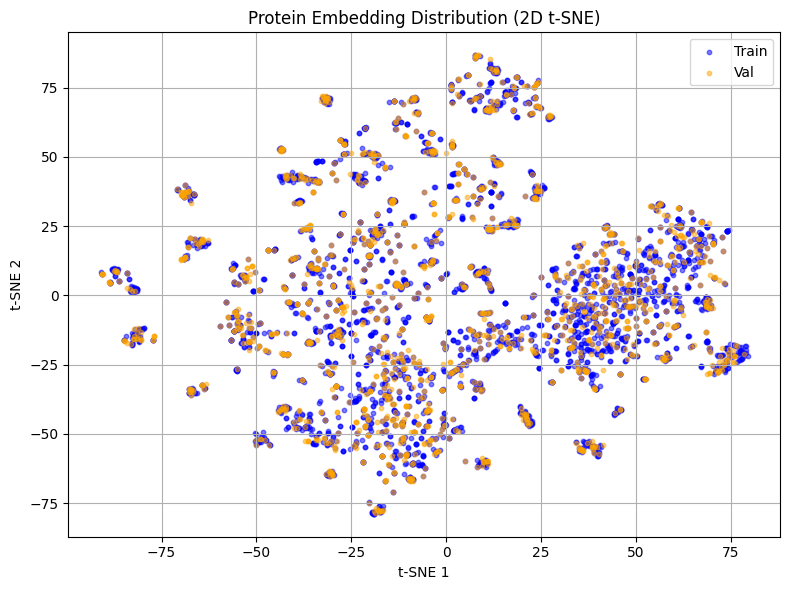

Embedding distance between Train and Val in t-SNE space:
Mean inter-distribution Euclidean distance: 67.3814


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from scipy.stats import entropy, wasserstein_distance
from scipy.spatial.distance import cdist



# === Plot 1: pic50 distribution comparison ===
plt.figure(figsize=(10, 4))
hist_train, bins = np.histogram(pic50_raw_agg_train, bins=50, density=True)
hist_val, _ = np.histogram(pic50_raw_agg_val, bins=bins, density=True)
bin_centers = 0.5 * (bins[1:] + bins[:-1])

plt.hist(pic50_raw_agg_train, bins=bins, alpha=0.5, label="Train", color="blue", density=True)
plt.hist(pic50_raw_agg_val, bins=bins, alpha=0.5, label="Val", color="orange", density=True)
plt.title("pic50 Distribution: Train vs. Val")
plt.xlabel("pic50")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Distribution Similarity Metrics (pic50) ===
eps = 1e-8
kl_div = entropy(hist_train + eps, hist_val + eps)
wass_dist = wasserstein_distance(pic50_raw_agg_train, pic50_raw_agg_val)

print(f"Distribution similarity (pic50):")
print(f"KL divergence:         {kl_div:.4f}")
print(f"Wasserstein distance:  {wass_dist:.4f}")



# === Plot 2: protein embedding distribution via t-SNE ===
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_2d = tsne.fit_transform(np.concatenate([prot_raw_agg_train, prot_raw_agg_val], axis=0))
prot_raw_agg_train_2d = X_2d[:len(prot_raw_agg_train)]
prot_raw_agg_val_2d = X_2d[len(prot_raw_agg_train):]

plt.figure(figsize=(8, 6))
plt.scatter(prot_raw_agg_train_2d[:, 0], prot_raw_agg_train_2d[:, 1], alpha=0.5, label="Train", color="blue", s=10)
plt.scatter(prot_raw_agg_val_2d[:, 0], prot_raw_agg_val_2d[:, 1], alpha=0.5, label="Val", color="orange", s=10)
plt.title("Protein Embedding Distribution (2D t-SNE)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Embedding Distribution Distance ===
# Compute average pairwise distance between train and val
dist_matrix = cdist(prot_raw_agg_train_2d, prot_raw_agg_val_2d, metric='euclidean')
mean_inter_dist = np.mean(dist_matrix)

print(f"Embedding distance between Train and Val in t-SNE space:")
print(f"Mean inter-distribution Euclidean distance: {mean_inter_dist:.4f}")


The distributions look quiet matching. Lets proceed to the next stage. Here we further split the data : the raw pic50, the id's and the real embeddings features. Then we Standardize, PCA and L2-normalize it. Also give the raw protein data labels from the agregated data, that will be usefull later when finding out the distances between proteins quicker from the precomputed distance matrix.

In [7]:
# Map aggregated indices back to raw indices
# raw_train_idx and raw_val_idx are just like train_agg_idx, val_agg_idx but now it's indexes from the full data, after filtering data

raw_train_idx = [idx for agg_i in agg_idx[train_agg_idx] for idx in dict_agg_label_to_idx_raw[agg_i]]
raw_val_idx = [idx for agg_i in agg_idx[val_agg_idx] for idx in dict_agg_label_to_idx_raw[agg_i]]


# Raw splits
pic50_raw_train = pic50_raw[raw_train_idx]
pic50_raw_val = pic50_raw[raw_val_idx]
ids_raw_train = ids_raw[raw_train_idx]
ids_raw_val = ids_raw[raw_val_idx]
fs_raw_train = fs_raw[raw_train_idx]
fs_raw_val = fs_raw[raw_val_idx]


In [8]:


# === Step 4: Preprocess raw embeddings (Standardize + PCA) ===
fs_raw_train_scaler = StandardScaler().fit(fs_raw_train)
fs_raw_train_std = fs_raw_train_scaler.transform(fs_raw_train)
fs_raw_val_std = fs_raw_train_scaler.transform(fs_raw_val)

fs_raw_train_std_pcascaler = PCA(n_components=0.95).fit(fs_raw_train_std)
X_train = fs_raw_train_std_pcascaler.transform(fs_raw_train_std)
X_val = fs_raw_train_std_pcascaler.transform(fs_raw_val_std)

#  = normalize(fs_raw_train_std_pca, norm='l2')
#  = normalize(fs_raw_val_std_pca, norm='l2')


# === Step 5: Assign protein cluster labels (from aggregated proteins) to raw samples ===
protein_clusters_agg = clusters  # from above KMeans on aggregated proteins
protein_cluster_labels_raw = np.empty(sum(len(v) for v in dict_agg_label_to_idx_raw.values()), dtype=int)

for agg_idx_, raw_indices in dict_agg_label_to_idx_raw.items():
    label = protein_clusters_agg[agg_idx_]
    protein_cluster_labels_raw[raw_indices] = label

protein_cluster_labels_train = protein_cluster_labels_raw[raw_train_idx]
protein_cluster_labels_val = protein_cluster_labels_raw[raw_val_idx]



Lets now visualise the train and val embeddings, by how they currently cluster, protein k-means-class-wise, and pic50-bin-wise and combined-wise

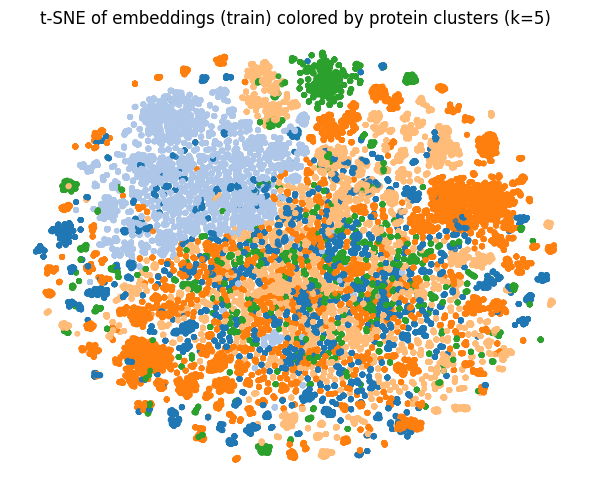

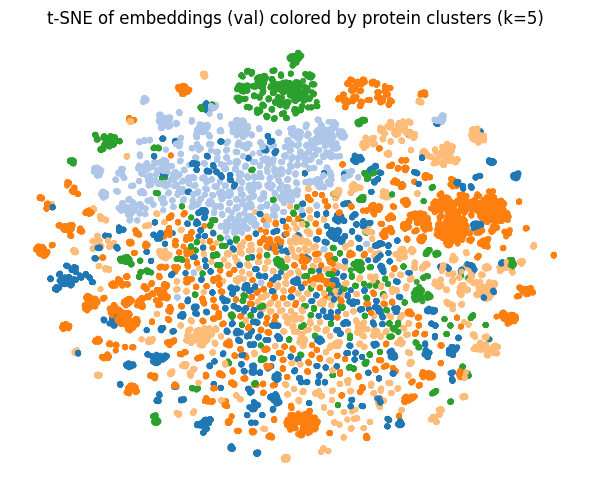

/media/racah/2b2b05ab-497e-47ab-a698-6e77a3b775c4/grisha/for_ProtLigMap/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_discretization.py:296: FutureWarning: The current default behavior, quantile_method='linear', will be changed to quantile_method='averaged_inverted_cdf' in scikit-learn version 1.9 to naturally support sample weight equivalence properties by default. Pass quantile_method='averaged_inverted_cdf' explicitly to silence this warning.
  warnings.warn(


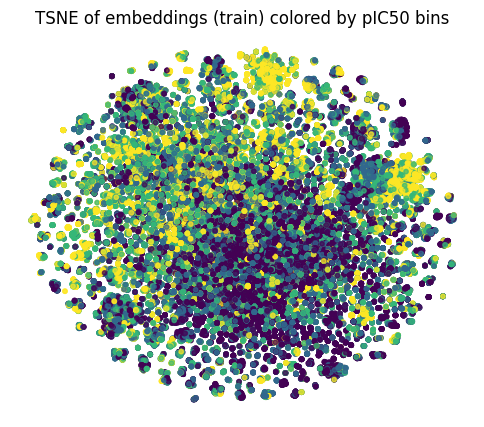

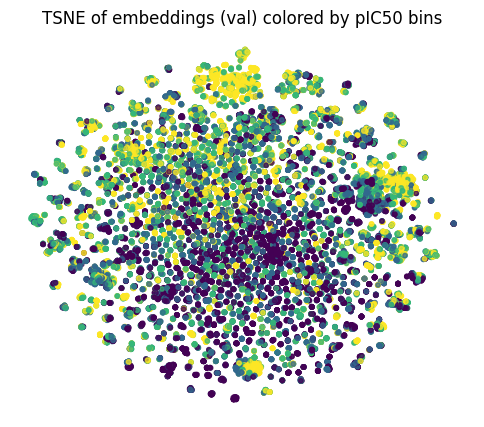

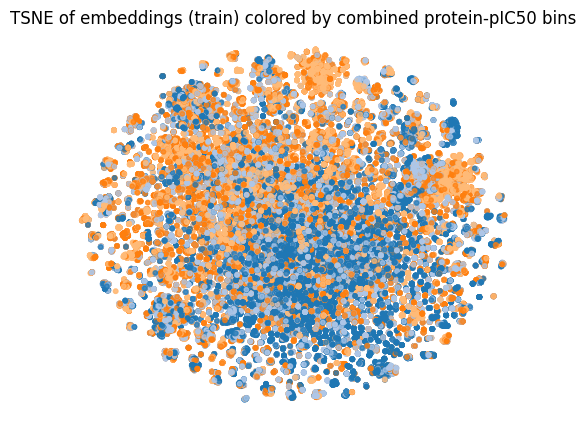

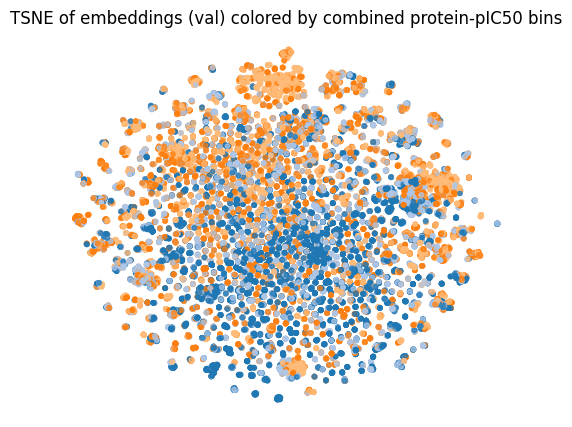

In [10]:
# === Step 6: Visualizations ===

# Protein clusters TSNE plots with different cluster numbers on aggregated proteins,
# mapped back to raw samples colors.

k_means_clusters_list = [5]

for k in k_means_clusters_list:
    # Cluster on aggregated normalized vectors
    km_agg = KMeans(n_clusters=k, random_state=42)
    km_agg.fit(prot_agg_proc)
    protein_clusters_agg_k = km_agg.labels_  # shape: (num_aggregated_proteins,)

    # Map cluster labels back to raw protein instances
    protein_cluster_labels_raw_k = np.full_like(protein_cluster_labels_raw, fill_value=-1)  # safer init

    for agg_idx_, raw_indices in dict_agg_label_to_idx_raw.items():
        label = protein_clusters_agg_k[agg_idx_]
        protein_cluster_labels_raw_k[raw_indices] = label

    # Sanity check
    assert not np.any(protein_cluster_labels_raw_k == -1), "Some raw proteins were not assigned a cluster!"

    # Extract cluster labels for train/val
    protein_cluster_labels_train_k = protein_cluster_labels_raw_k[raw_train_idx]
    protein_cluster_labels_val_k = protein_cluster_labels_raw_k[raw_val_idx]

    # Visualize each split with t-SNE
    for name, X, clusters in [('train', X_train, protein_cluster_labels_train_k),
                              ('val', X_val, protein_cluster_labels_val_k)]:
        
        tsne = TSNE(n_components=2, random_state=42, perplexity=30)
        E2d = tsne.fit_transform(X)

        cmap = plt.get_cmap('tab20' if k <= 20 else 'tab20b')
        colors = cmap((clusters % cmap.N) / cmap.N)

        plt.figure(figsize=(6, 5))
        plt.scatter(E2d[:, 0], E2d[:, 1], c=colors, s=10, alpha=0.7)
        plt.title(f"t-SNE of embeddings ({name}) colored by protein clusters (k={k})")
        plt.axis('off')
        plt.tight_layout()
        plt.show()



# TSNE colored by pIC50 quantile bins (4 bins)
binner = KBinsDiscretizer(n_bins=n_pic50_bins_all, encode='ordinal', strategy='quantile')
pic50_train_bins = binner.fit_transform(pic50_raw_train.reshape(-1, 1)).flatten().astype(int)
pic50_val_bins = binner.transform(pic50_raw_val.reshape(-1, 1)).flatten().astype(int)

for name, X, bins in [('train', X_train, pic50_train_bins), ('val', X_val, pic50_val_bins)]:
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    E2d = tsne.fit_transform(X)
    cmap = plt.get_cmap('viridis')
    colors = cmap((bins % cmap.N) / bins.max())
    plt.figure(figsize=(6,5))
    plt.scatter(E2d[:, 0], E2d[:, 1], c=colors, s=10, alpha=0.7)
    plt.title(f"TSNE of embeddings ({name}) colored by pIC50 bins")
    plt.axis('off')
    plt.show()



# TSNE colored by combined protein-pIC50 bins (using k=5 protein clusters as example)
tmp_k = 5
km_tmp = KMeans(n_clusters=tmp_k, random_state=42)
km_tmp.fit(prot_agg_proc)
protein_clusters_agg_tmp = km_tmp.labels_

protein_cluster_labels_raw_tmp = np.empty_like(protein_cluster_labels_raw)
for agg_idx_, raw_indices in dict_agg_label_to_idx_raw.items():
    protein_cluster_labels_raw_tmp[raw_indices] = protein_clusters_agg_tmp[agg_idx_]

protein_cluster_labels_train_tmp = protein_cluster_labels_raw_tmp[raw_train_idx]
protein_cluster_labels_val_tmp = protein_cluster_labels_raw_tmp[raw_val_idx]

combined_train = protein_cluster_labels_train_tmp * 100 + pic50_train_bins
combined_val = protein_cluster_labels_val_tmp * 100 + pic50_val_bins

for name, X, labels in [('train', X_train, combined_train), ('val', X_val, combined_val)]:
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    E2d = tsne.fit_transform(X)
    n_classes = len(np.unique(labels))
    cmap = plt.get_cmap('tab20' if n_classes <= 20 else 'tab20b')
    colors = cmap((labels % cmap.N) / cmap.N)
    plt.figure(figsize=(6,5))
    plt.scatter(E2d[:, 0], E2d[:, 1], c=colors, s=10, alpha=0.7)
    plt.title(f"TSNE of embeddings ({name}) colored by combined protein-pIC50 bins")
    plt.axis('off')
    plt.show()


Now lets preprocess the proteins and pic50 final values that we will use for train and split

In [11]:
from sklearn.metrics.pairwise import cosine_distances
from sklearn.preprocessing import MinMaxScaler, StandardScaler, normalize
import numpy as np
from sklearn.decomposition import PCA


# === Step 1: Standardize, PCA ===
prot_raw_agg_train_scaler = StandardScaler().fit(prot_raw_agg_train)
prot_raw_agg_train_std = prot_raw_agg_train_scaler.transform(prot_raw_agg_train)
prot_raw_agg_val_std = prot_raw_agg_train_scaler.transform(prot_raw_agg_val)

pca = PCA(n_components=0.95).fit(prot_raw_agg_train_std)
prot_train_agg = pca.transform(prot_raw_agg_train_std)
prot_val_agg = pca.transform(prot_raw_agg_val_std)


dist_matrix_prot_train = cdist(prot_train_agg, prot_train_agg, metric='euclidean')
prot_sim_train = 1 / (1 + dist_matrix_prot_train)

dist_matrix_prot_val = cdist(prot_val_agg, prot_val_agg, metric='euclidean')
prot_sim_val = 1 / (1 + dist_matrix_prot_val)



# === Step 4: MinMax scale aggregated pic50 values ===


# Step 1: Standardize (fit only on train)
std_scaler = StandardScaler().fit(pic50_raw_train.reshape(-1, 1))
pic50_train = std_scaler.transform(pic50_raw_train.reshape(-1, 1))
pic50_val = std_scaler.transform(pic50_raw_val.reshape(-1, 1))



Next, we build the mapping from train index number value to the number of index in the agregated proteins indexes. That will be used for finding quickly the distance between proteins, given index number of training example (same for val)

In [12]:
# Build reverse mapping: raw index → aggregated protein index
raw_to_agg = {}
for agg_idx, raw_idxs in dict_agg_label_to_idx_raw.items():
    for raw_idx in raw_idxs:
        raw_to_agg[raw_idx] = agg_idx
        
train_idx_to_agg = np.array([raw_to_agg[idx] for idx in raw_train_idx])
val_idx_to_agg = np.array([raw_to_agg[idx] for idx in raw_val_idx])

# Mapping: global aggregated index → local index within prot_sim_train
agg_to_local_train = {agg_idx: i for i, agg_idx in enumerate(sorted(set(train_idx_to_agg)))}
agg_to_local_val = {agg_idx: i for i, agg_idx in enumerate(sorted(set(val_idx_to_agg)))}


So during training and validation , we can call from the distance matrix prot_sim_train the specific protein distances from row agg_to_local_train[i] and column agg_to_local_train[j], given i and j the indexes in train set (same for validation)

idx_to_agg will be changed to agg_to_local_train and agg_to_local_val in regards to if we are training or validating


idx = torch.tensor([agg_to_local_map[int(a)] for a in idx_to_agg], device=prot_dist_mat.device)
protein_sim = 1.0 - prot_dist_mat[idx[:, None], idx[None, :]]


Another thing we need to generate is prot_idx_train and prot_idx_val which are the protein indexes of all the training and val examples. Protein index is the index in the agregated unique_agg_labels which is all unique proteins we have. we'll use it later for lots of tasks like colouring on plots our data protein wise, and later tasks of further ML.

In [13]:
# Step 1: Build raw index → protein index in prot_raw_agg_filtered
raw_idx_to_prot_idx = {}
agg_idx = np.where(mask)[0]
for i, agg_i in enumerate(agg_idx):  # i is index into prot_raw_agg_filtered
    for raw_idx in dict_agg_label_to_idx_raw[agg_i]:
        raw_idx_to_prot_idx[raw_idx] = i

# Step 2: For each training/validation example, find the protein index
prot_idx_train = [raw_idx_to_prot_idx[raw_idx] for raw_idx in raw_train_idx]
prot_idx_val   = [raw_idx_to_prot_idx[raw_idx] for raw_idx in raw_val_idx]

Finnally, lets now wrap up all the data we are going to use for our training in a placeholder, that will be input in the final model run 

In [14]:

embeddings = [X_train, X_val]
pic50 = [pic50_train, pic50_val]
prot_sim_mat = [prot_sim_train, prot_sim_val]
valid_keys = [ids_raw_train, ids_raw_val]
idx_to_agg = [train_idx_to_agg, val_idx_to_agg]
agg_to_local = [agg_to_local_train, agg_to_local_val]
pic50_raw = [pic50_raw_train, pic50_raw_val]
prot_idx = [prot_idx_train, prot_idx_val]
prot_raw_agg_filtered_into_model = [prot_raw_agg_filtered.copy(), [0]]

all_data_grouped_original = {
    "embeddings": embeddings,
    "pic50": pic50,
    "prot_sim_mat": prot_sim_mat,
    "valid_keys": valid_keys,
    "idx_to_agg" : idx_to_agg,
    "agg_to_local": agg_to_local,
    "pic50_raw": pic50_raw,
    "prot_idx": prot_idx,
    "prot_raw_agg_filtered_into_model": prot_raw_agg_filtered_into_model
}

input_for_placeholder = {}

for key, (object_train, object_val) in all_data_grouped_original.items():
    input_for_placeholder[key] = {
        'train': object_train,
        'val': object_val
    }

In [15]:
import torch
from torch.utils.data import Dataset, DataLoader


class ProteinLigandDataset(Dataset):
    def __init__(self, embeddings, pic50, prot_sim_mat, valid_keys, idx_to_agg, agg_to_local, pic50_raw, prot_idx, prot_raw_agg_filtered_into_model):

        self.embeddings = torch.tensor(embeddings, dtype=torch.float32)
        self.pic50 = torch.tensor(pic50, dtype=torch.float32)
        self.prot_sim_mat = torch.tensor(prot_sim_mat, dtype=torch.float32)
        self.valid_keys = valid_keys
        self.idx_to_agg = torch.tensor(idx_to_agg, dtype=torch.float32)
        self.agg_to_local = agg_to_local
        self.pic50_raw = torch.tensor(pic50_raw, dtype=torch.float32)
        self.prot_idx = torch.tensor(prot_idx, dtype=torch.int64)
        self.prot_raw_agg_filtered_into_model = torch.tensor(prot_raw_agg_filtered_into_model, dtype=torch.float32)

    def __len__(self):
        return len(self.pic50)

    def __getitem__(self, idx):
        return self.embeddings[idx], self.pic50[idx], self.idx_to_agg[idx]
    



# Get all split names from any key (assuming all keys have same splits)
splits = list(next(iter(input_for_placeholder.values())).keys())

datasets = {}
for split in splits:
    split_data = {key: val[split] for key, val in input_for_placeholder.items()}
    datasets[split] = ProteinLigandDataset(**split_data)



In [16]:
import torch

# Save raw input data for all splits
torch.save(datasets, '../outputs/datasets.pt')
